In [22]:
import anndata
import matplotlib as mpl
import pandas as pd
import seaborn as sns
# from scipy.optimize import curve_fit
%run cc_score_from_scanpy
%run loading_tissue
%run score_cc_finding

In [9]:
save_dir='Figures\Compairson scoring methods'
mpl.style.use('seaborn')
sns.set_style('whitegrid')

rc_pars = {'legend.facecolor': 'white', 'legend.framealpha': 0.85, "lines.linewidth": 3,
                            'legend.edgecolor':'Black', 'legend.frameon': True,
                            'legend.fancybox': True, 'legend.shadow': False,
                             'figure.figsize': [10, 7],'figure.dpi': 300}
                            # 'axes.labelsize': 28, 'xtick.labelsize': 24, 'font.size': 28,
                            # 'ytick.labelsize': 24, 'axes.titlesize': 28,
                            # 'legend.title_fontsize':22, 'legend.fontsize': 22})
sns.set_context('talk',  rc=rc_pars )

In [70]:
path = 'C:/Users/ronse/Dropbox (Weizmann Institute)/scRNA cell analysis/Datasets/Unlabeled/Kowalczyk 2015/'
fname = 'GSE59114_C57BL6_GEO_all.csv'
kow_data = pd.read_csv(path + fname, skiprows=1, index_col=0).T
kow_data = kow_data.drop('UCSC transcripts')
kow_data.columns = kow_data.columns.str.replace("'",'').str.upper()
kow_data.head()
ad = anndata.AnnData(kow_data)
ad.var_names_make_unique()
sc.pp.filter_genes(ad, min_cells=10)
ad = ad[np.sum(ad.X>2, axis=1)>2500,:]
# sc.pp.filter_cells(ad, min_genes=2500)
ad.obs['n_counts'] = np.sum(ad.X, axis=1)
ad = ad[ad.obs.n_counts>10000]
sc.pp.normalize_per_cell(ad, counts_per_cell_after=1e4)
ad = sc.pp.filter_genes_dispersion(ad, subset = False, min_disp=.5, max_disp=None, min_mean=.0125, max_mean=10,
n_bins=20, n_top_genes=None, log=True, copy=True)
# sc.pp.log1p(ad)
# sc.pp.scale(ad, zero_center=False, )
# sc.pp.scale(ad, zero_center=False, max_value=10)
# sc.pp.scale(ad, zero_center=True, max_value=10)
# sc.pp.scale(ad, zero_center=True)
# ad.X = ad.X - np.mean(ad.X, axis=0)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


In [73]:
sc.pp.scale(ad, zero_center=True)

n_counts             cell     yo term     labels
young_LT_HSC_2   20028.994141   young_LT_HSC_2  young   LT   young-LT
young_LT_HSC_6   18563.082031   young_LT_HSC_6  young   LT   young-LT
young_LT_HSC_8   21626.798828   young_LT_HSC_8  young   LT   young-LT
young_LT_HSC_9   23643.148438   young_LT_HSC_9  young   LT   young-LT
young_LT_HSC_10  22520.578125  young_LT_HSC_10  young   LT   young-LT
...                       ...              ...    ...  ...        ...
'Young ST-HSC'   46531.093750   'Young ST-HSC'  young   ST   young-ST
'Young MPP'      45369.046875      'Young MPP'  young  MPP  young-MPP
'Old LT-HSC'     44824.343750     'Old LT-HSC'    old   LT     old-LT
'Old ST-HSC'     44603.003906     'Old ST-HSC'    old   ST     old-ST
Old MPP'         43903.671875         Old MPP'    old  MPP    old-MPP

[1271 rows x 5 columns]

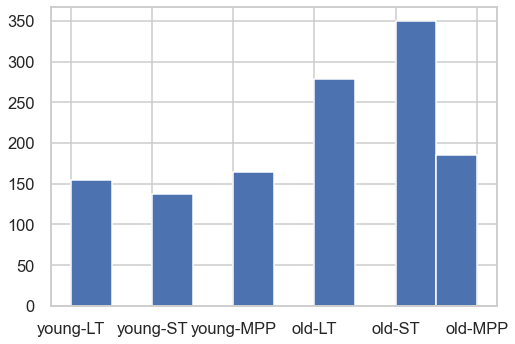

In [71]:
ad.obs['cell'] = ad.obs.index
ad.obs['yo'] = 0
ad.obs['term'] = 0

for yo in ['young', 'old']: 
    ad.obs.loc[ad.obs.index.str.replace("'",'').str.lower().str.contains(yo),'yo'] = yo
for term in ['ST', 'LT', 'MPP']: 
    ad.obs.loc[ad.obs.index.str.replace("'",'').str.contains(term),'term'] = term
ad.obs['labels'] = ad.obs.yo + '-' +  ad.obs.term
ad.obs.labels.hist()
ad.obs


Kowalczyk


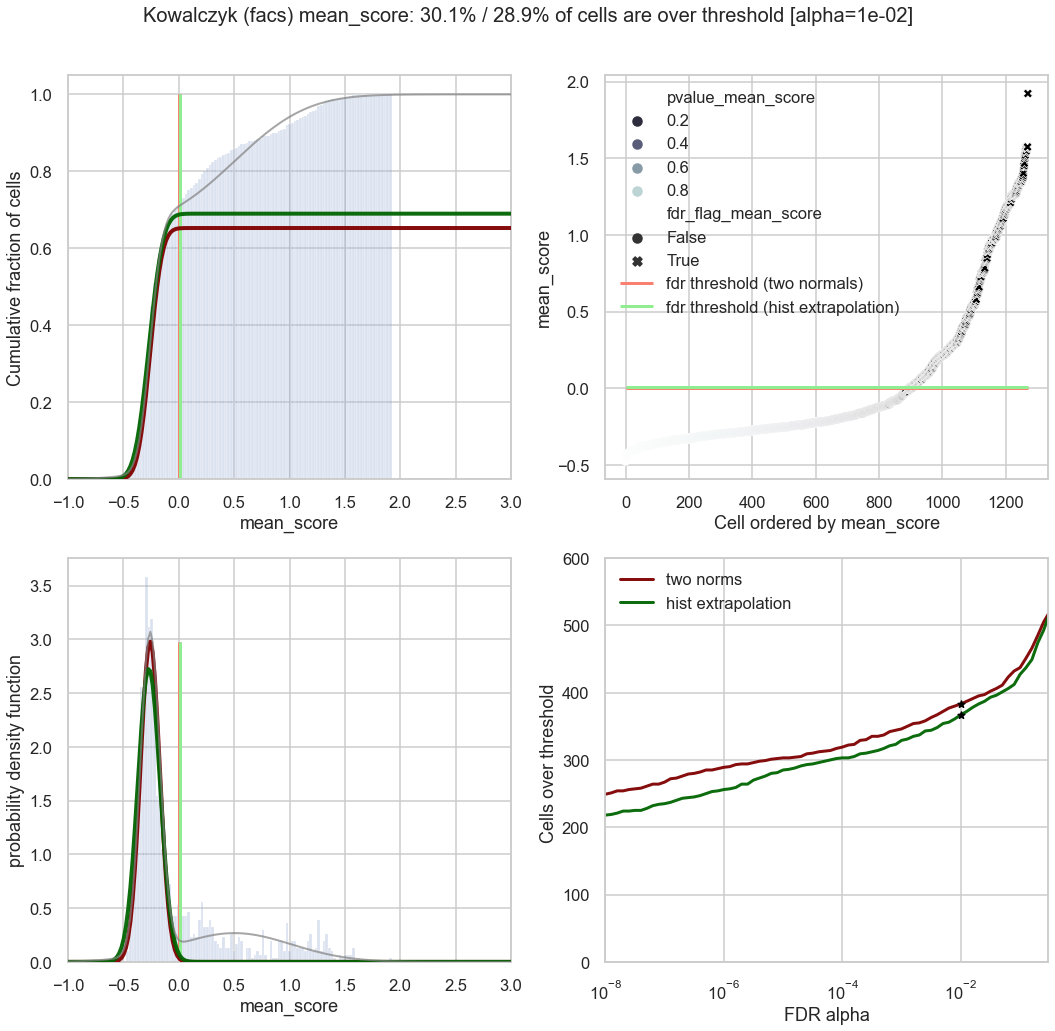

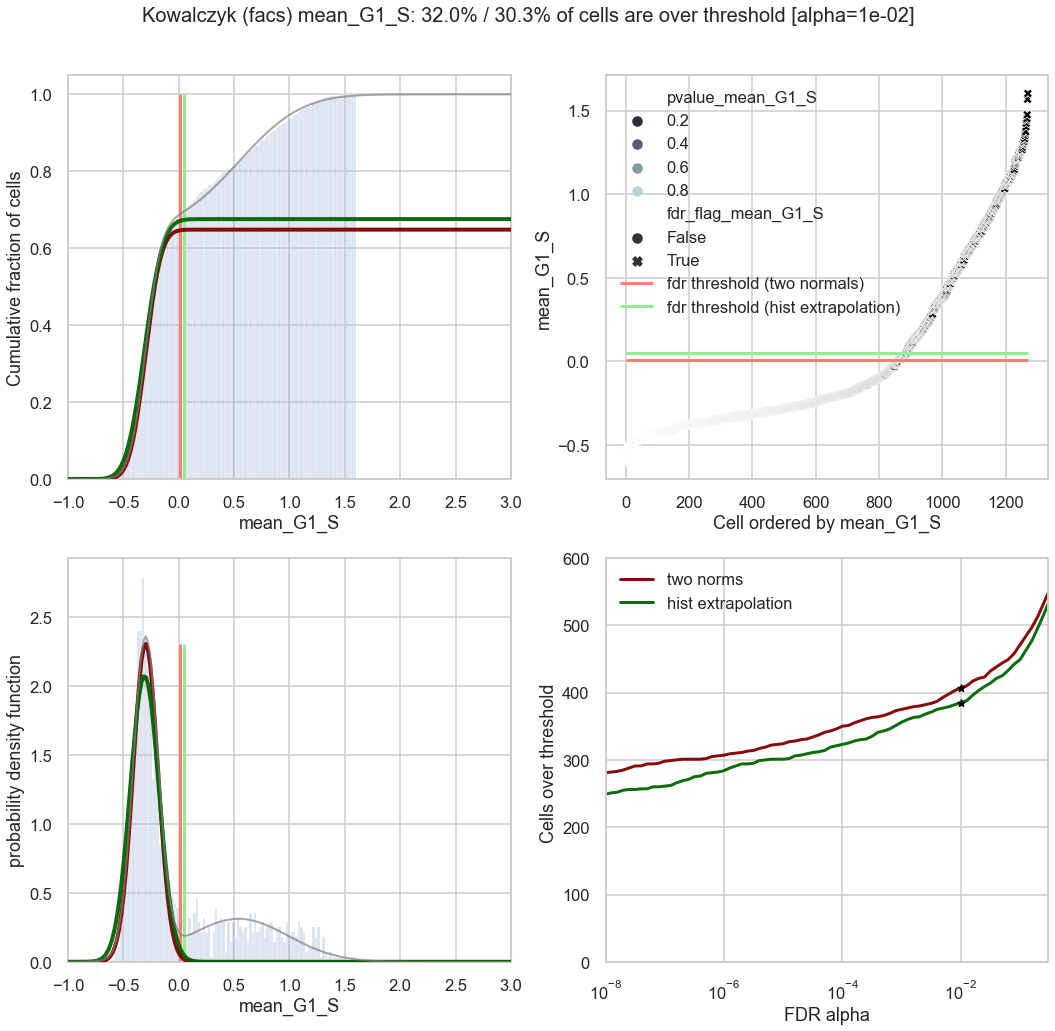

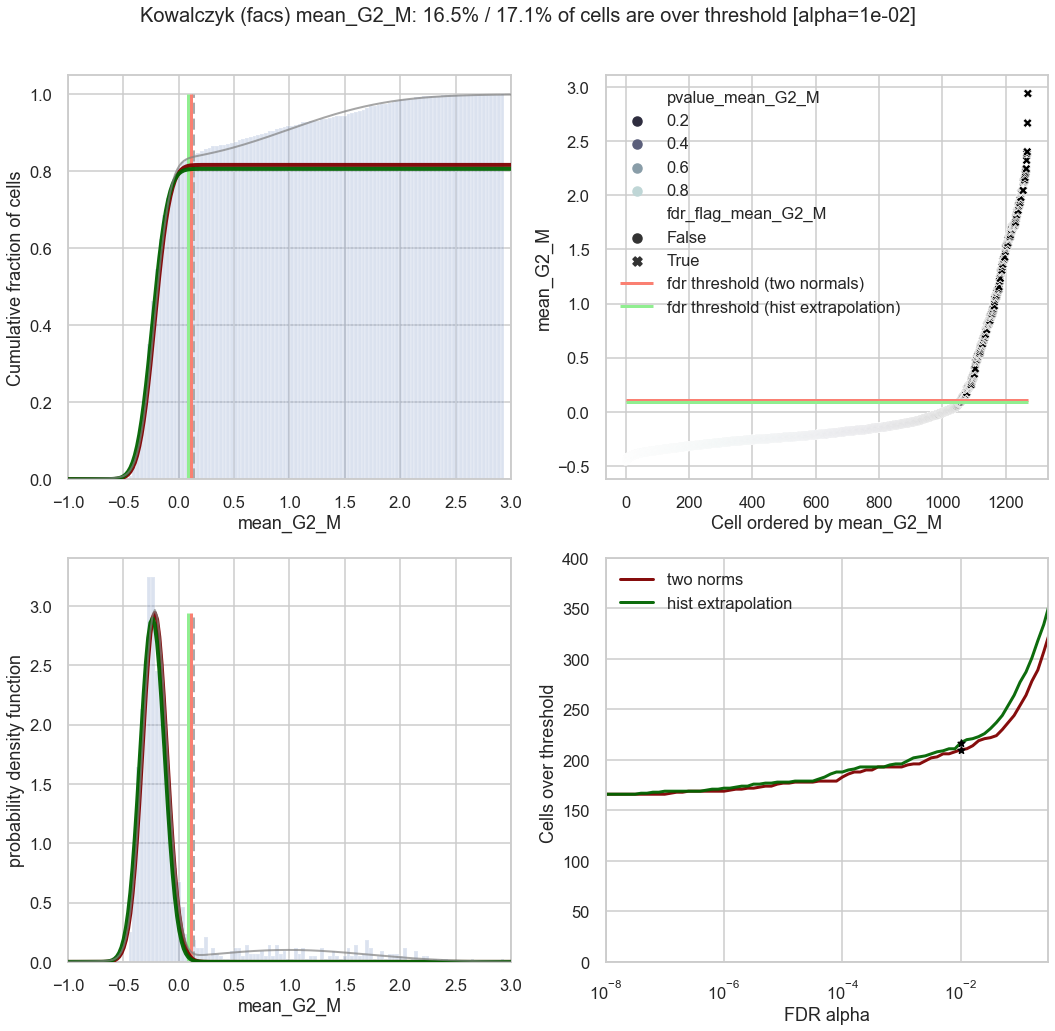

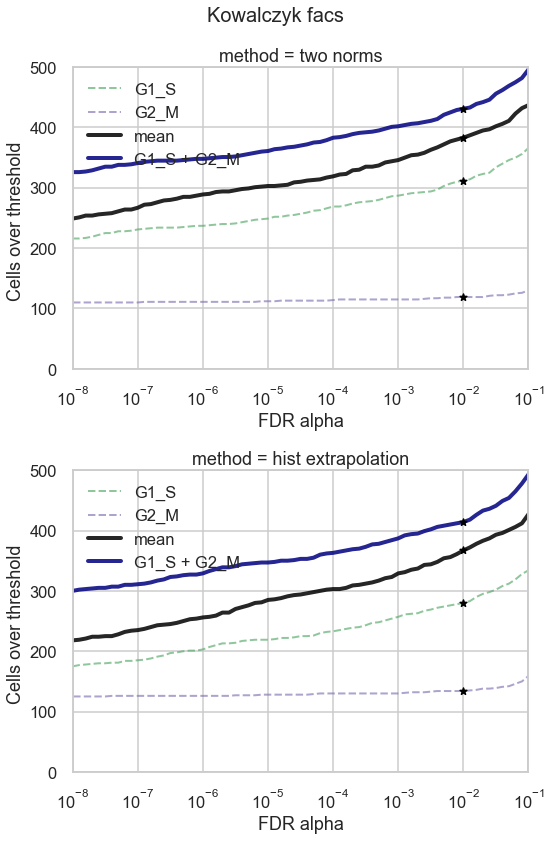

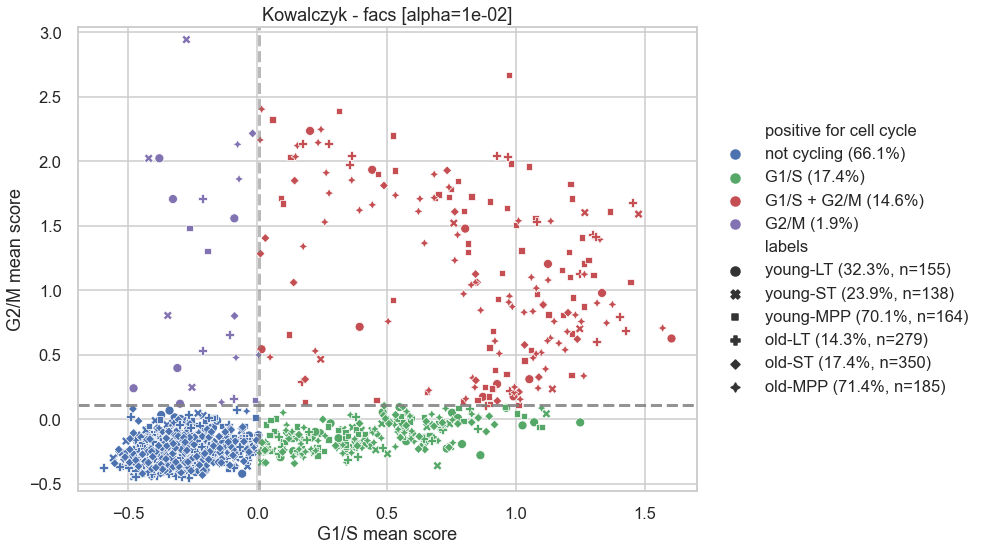

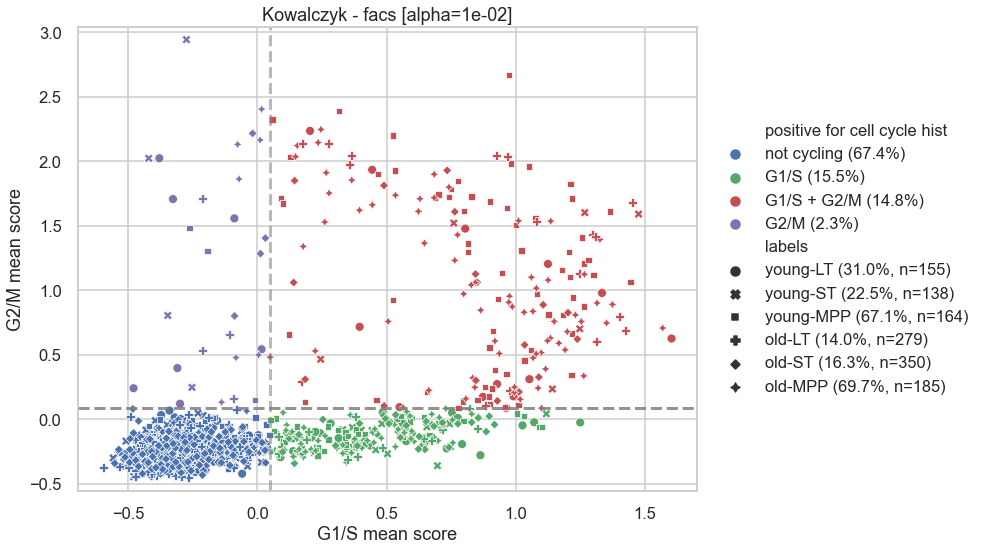

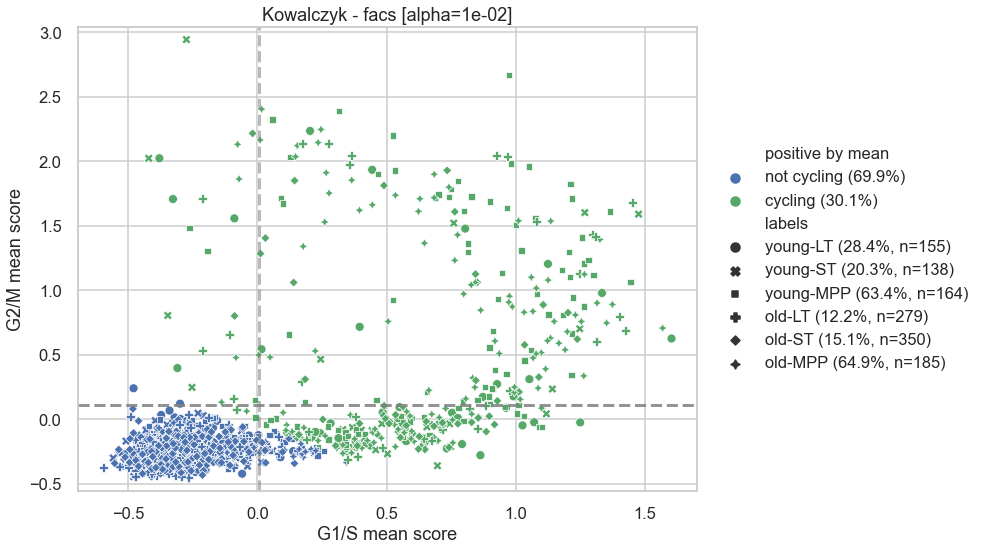

In [74]:
tissue_name = 'Kowalczyk'
print(tissue_name)
# with warnings.catch_warnings():
#     warnings.simplefilter("ignore")
#     ad = load_tissue_as_ad(tissue_name)
#     ad = preprocess_ad(ad)
# cc_genes_df = get_relevant_glist(ad, glist_name='Whitfield')
ad.obs['method'] = 'facs'
df_scores = get_phases_scores(ad, glist_name='Whitfield', corr_thr=0.25)
df_scores, norm_fit_df = get_fdr_cc_scores(df_scores, fdr_alpha=0.01)
plot_cc_scores(df_scores, norm_fit_df, score='mean_score', tissue_name=tissue_name, save_flag=True)
plot_cc_scores(df_scores, norm_fit_df, score='mean_G1_S', tissue_name=tissue_name, save_flag=True)
plot_cc_scores(df_scores, norm_fit_df, score='mean_G2_M', tissue_name=tissue_name, save_flag=True)
# plt.savefig('Figures/{}-mean_score.png'.format(tissue_name))
# plot_phases_positive_vs_fdr(df_scores, fdr_alpha=0.01)
plot_positive_vs_fdr_comparison(df_scores, fdr_alpha=0.01, tissue_name=tissue_name, save_flag=True)
# plt.savefig('Figures/{}-pos_vs_fdr.png'.format(tissue_name))
# df_scores.to_csv('{}/{}.csv'.format(res_dir, tissue_name))
for hue in ['positive_for_cell_cycle', 'positive_by_mean']:
    for method in ['two_norms', 'hist']:
        scatter_phase_score_by(df_scores, norm_fit_df, method=method, hue=hue,
                        by='labels', tissue_name=tissue_name, save_flag=True)

In [79]:
#Score cell cycle and visualize the effect:
# cc_genes_file = '../MRGR_Stress/Macosko_cell_cycle_genes.txt'
cc_genes_file = '../Sources/Genes lists/Macosko et al., 2015 - SI Table S2.xlsx'
cc_genes = pd.read_excel(cc_genes_file, sheet_name='Gene Sets Used in Analysis')

# cc_genes = pd.read_table(cc_genes_file, delimiter='\t')
s_genes = cc_genes['S'].dropna()
g2m_genes = cc_genes['G2/M'].dropna()
s_genes = s_genes.apply(lambda s: s.split(' ')[-1]) 
#list(zip(*s_genes.str.split(' ')))[-1]
g2m_genes = g2m_genes.apply(lambda s: s.split(' ')[-1])

#  list(zip(*g2m_genes.str.split(' ')))[-1]

# s_genes_mm = [gene.lower().capitalize() for gene in s_genes]
# g2m_genes_mm = [gene.lower().capitalize() for gene in g2m_genes]

s_genes_mm_ens = ad.var_names[np.in1d(ad.var_names, s_genes)]
g2m_genes_mm_ens = ad.var_names[np.in1d(ad.var_names, g2m_genes)]

score_genes_cell_cycle(ad, s_genes=s_genes_mm_ens, g2m_genes=g2m_genes_mm_ens)

In [78]:
ad.obs['S_score_no_scale'] = ad.obs.S_score
ad.obs['G2M_score_no_scale'] = ad.obs.G2M_score
ad.obs['phase_no_scale'] = ad.obs.phase

In [62]:
cc_mack = cc_genes.melt(var_name='Phase', value_name='gene_name')
cc_mack = cc_mack.dropna()
cc_mack.gene_name = cc_mack.gene_name.apply(lambda s: s.split(' ')[-1])
cc_mack.index = cc_mack.gene_name
cc_mack

Phase gene_name
gene_name                
ACD        G1/S       ACD
ACYP1      G1/S     ACYP1
ADAMTS1    G1/S   ADAMTS1
ANKRD10    G1/S   ANKRD10
APEX2      G1/S     APEX2
...         ...       ...
ZBTB7A     M/G1    ZBTB7A
ZCCHC10    M/G1   ZCCHC10
ZNF24      M/G1     ZNF24
ZNF281     M/G1    ZNF281
ZNF593     M/G1    ZNF593

[603 rows x 2 columns]

In [51]:
ad.obs

n_counts             cell     yo term     labels method  \
young_LT_HSC_2   20028.994141   young_LT_HSC_2  young   LT   young-LT   facs   
young_LT_HSC_6   18563.082031   young_LT_HSC_6  young   LT   young-LT   facs   
young_LT_HSC_8   21626.798828   young_LT_HSC_8  young   LT   young-LT   facs   
young_LT_HSC_9   23643.148438   young_LT_HSC_9  young   LT   young-LT   facs   
young_LT_HSC_10  22520.578125  young_LT_HSC_10  young   LT   young-LT   facs   
...                       ...              ...    ...  ...        ...    ...   
'Young ST-HSC'   46531.093750   'Young ST-HSC'  young   ST   young-ST   facs   
'Young MPP'      45369.046875      'Young MPP'  young  MPP  young-MPP   facs   
'Old LT-HSC'     44824.343750     'Old LT-HSC'    old   LT     old-LT   facs   
'Old ST-HSC'     44603.003906     'Old ST-HSC'    old   ST     old-ST   facs   
Old MPP'         43903.671875         Old MPP'    old  MPP    old-MPP   facs   

                     G1/S         S        G2      G2/M  ...  \
young_LT_HSC_2  -0.321087 -0.203919 -0.123012 -0.358178  ...   
young_LT_HSC_6  -0.261963 -0.413500 -0.245484 -0.087155  ...   
young_LT_HSC_8  -0.403531 -0.164276 -0.300502 -0.224596  ...   
young_LT_HSC_9   0.322035  0.181180 -0.187991 -0.025965  ...   
young_LT_HSC_10  0.585041  0.560670 -0.082836 -0.046223  ...   
...                   ...       ...       ...       ...  ...   
'Young ST-HSC'   0.183895  0.292716  0.395870  0.535892  ...   
'Young MPP'      0.405593  0.619787  0.822295  1.028262  ...   
'Old LT-HSC'     0.128924  0.202824  0.235796  0.345838  ...   
'Old ST-HSC'     0.135539  0.224067  0.256911  0.364255  ...   
Old MPP'         0.409422  0.581355  0.679949  0.837805  ...   

                 fdr_hist_mean_G2_M  over_th  positive_for_cell_cycle  \
young_LT_HSC_2         8.230568e-01        0              not cycling   
young_LT_HSC_6         6.310291e-01        0              not cycling   
young_LT_HSC_8         8.391334e-01        0              not cycling   
young_LT_HSC_9         3.882190e-01        1                     G1/S   
young_LT_HSC_10        2.273187e-01        1                     G1/S   
...                             ...      ...                      ...   
'Young ST-HSC'         8.894489e-10        3              G1/S + G2/M   
'Young MPP'            6.354363e-25        3              G1/S + G2/M   
'Old LT-HSC'           6.798549e-06        3              G1/S + G2/M   
'Old ST-HSC'           2.802695e-06        3              G1/S + G2/M   
Old MPP'               1.343140e-18        3              G1/S + G2/M   

                 over_th_hist  positive_for_cell_cycle_hist  positive_by_mean  \
young_LT_HSC_2              0                   not cycling       not cycling   
young_LT_HSC_6              0                   not cycling       not cycling   
young_LT_HSC_8              0                   not cycling       not cycling   
young_LT_HSC_9              1                          G1/S           cycling   
young_LT_HSC_10             1                          G1/S           cycling   
...                       ...                           ...               ...   
'Young ST-HSC'              3                   G1/S + G2/M           cycling   
'Young MPP'                 3                   G1/S + G2/M           cycling   
'Old LT-HSC'                3                   G1/S + G2/M           cycling   
'Old ST-HSC'                3                   G1/S + G2/M           cycling   
Old MPP'                    3                   G1/S + G2/M           cycling   

                 positive_by_mean_hist   S_score  G2M_score  phase  
young_LT_HSC_2             not cycling -0.139939  -0.096248     G1  
young_LT_HSC_6             not cycling -0.204365   0.024743    G2M  
young_LT_HSC_8             not cycling -0.078128  -0.037647     G1  
young_LT_HSC_9                 cycling  0.321049  -0.028270      S  
young_LT_HSC_10                cycling  0.200048  -0.148236      S  
...                        

In [80]:
sns.scatterplot(data=ad.obs, x='S_score_no_scale', y='mean_G1_S', hue='phase_no_scale', style='positive_for_cell_cycle')
sns.move_legend(plt.gca(), loc='upper left',bbox_to_anchor=(1,1))

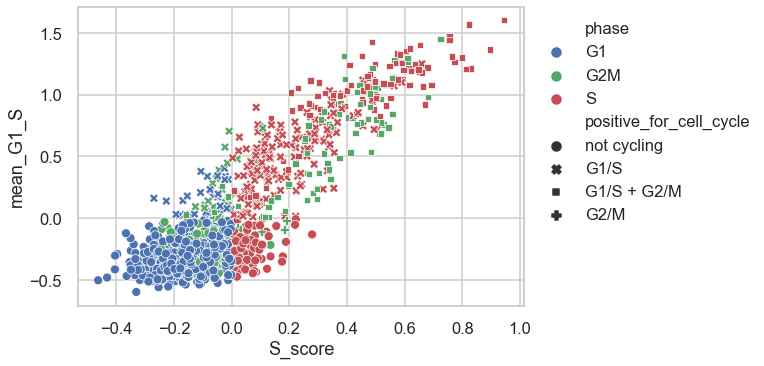

In [81]:
sns.scatterplot(data=ad.obs, x='S_score', y='mean_G1_S', hue='phase', style='positive_for_cell_cycle')
sns.move_legend(plt.gca(), loc='upper left',bbox_to_anchor=(1,1))

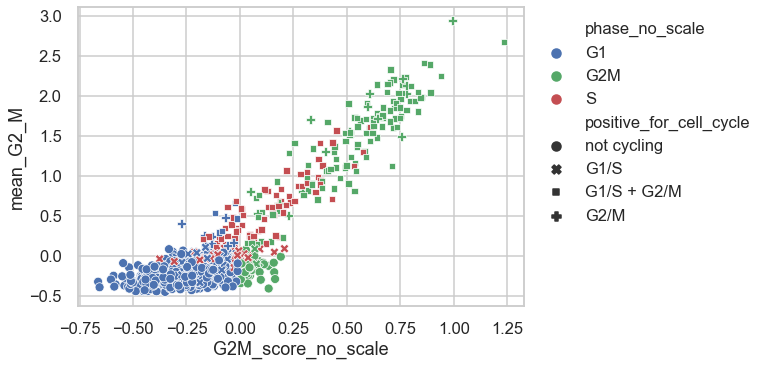

In [82]:
sns.scatterplot(data=ad.obs, x='G2M_score_no_scale', y='mean_G2_M', hue='phase_no_scale', style='positive_for_cell_cycle')
sns.move_legend(plt.gca(), loc='upper left',bbox_to_anchor=(1,1))

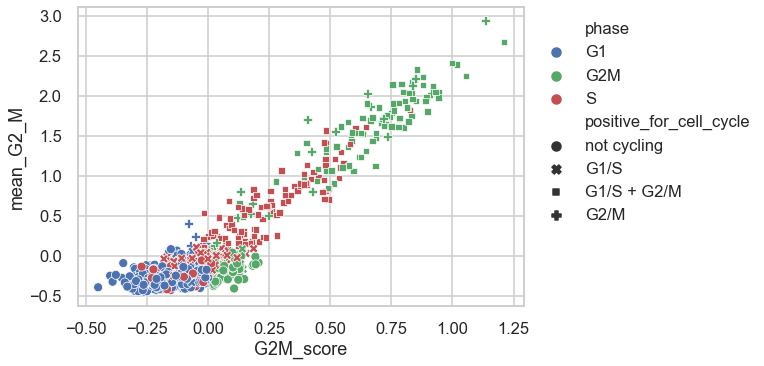

In [83]:
sns.scatterplot(data=ad.obs, x='G2M_score', y='mean_G2_M', hue='phase', style='positive_for_cell_cycle')
sns.move_legend(plt.gca(), loc='upper left',bbox_to_anchor=(1,1))

In [32]:
path= 'C:/Users/ronse/Dropbox (Weizmann Institute)/scRNA cell analysis/Sources/Genes lists/'
fname = 'Liu_2017_Table_S5.csv'
liu_score_genes = pd.read_csv(path + fname, index_col=0)
# cc_genes_GO = cc_genes_GO_df.Symbol.str.upper().unique()
# cc_score_genes.index.to_series().isin(df_red.columns).sum()
# cc_score_genes.index.to_series().isin(df_by_GO.columns).sum()

# ad.var_names.isin(cc_score_genes.index).sum()
liu_score_genes

Source       Identifier Peakstage  Rank  Peaktime
Gene                                                            
DTL      Homo sapiens  ENSP00000355958        G1    13        42
CCNE1    Homo sapiens  ENSP00000262643        G1    36        35
PTTG1    Homo sapiens  ENSP00000344936        G1    37         1
CDKN3    Homo sapiens  ENSP00000335357        G1    41         0
ZNF367   Homo sapiens  ENSP00000364405        G1    48        39
...               ...              ...       ...   ...       ...
LRRC17   Homo sapiens  ENSP00000344242         M    29        92
FAM64A   Homo sapiens  ENSP00000250056         M    31        92
BIRC5    Homo sapiens  ENSP00000301633         M    38        94
DEPDC1B  Homo sapiens  ENSP00000265036         M    42        90
SAPCD2   Homo sapiens  ENSP00000386348         M    47        96

[120 rows x 5 columns]

In [34]:
# wh_cc_genes = load_gene_list(glist_name='Whitfield')
# wh_cc_genes

    # fname = glists_fname_dicts[glist_name]
    # cc_genes_df = pd.read_excel(glists_path + fname, index_col=0)
    # cc_genes_df.index = cc_genes_df.index.str.upper()
    # return cc_genes_df
glist_name='Whitfield'
thr=0.25
cc_genes_df = load_gene_list(glist_name)
cc_genes_df['in_data'] = cc_genes_df.index.isin(ad.var_names)
cc_genes_red = cc_genes_df[cc_genes_df.in_data].copy()
cc_genes_red['above'] = False
for phase in cc_genes_red.Phase.unique():
    genes_in_phase = cc_genes_red.index[cc_genes_red.Phase == phase]
    df_in_phase = pd.DataFrame(ad[:, genes_in_phase].X.toarray(), columns=genes_in_phase)
    genes_above = df_in_phase.columns[df_in_phase.corrwith(df_in_phase.mean(axis=1)) > thr]
    cc_genes_red.loc[(cc_genes_red.Phase == phase) & (cc_genes_red.index.isin(genes_above)), 'above'] = True
cc_genes_red

Phase  in_data  above
Gene                         
ABCA7    G1/S     True  False
ACD      G1/S     True  False
ACYP1    G1/S     True  False
ADCK2    G1/S     True  False
ANKRD10  G1/S     True  False
...       ...      ...    ...
VPS37C   M/G1     True  False
XPO4     M/G1     True  False
YY1      M/G1     True  False
ZCCHC10  M/G1     True  False
ZNFX1    M/G1     True  False

[455 rows x 3 columns]

In [67]:
cc_mack['in_data'] = cc_mack.index.isin(ad.var_names)
cc_mack_red = cc_mack[cc_mack.in_data].copy()
cc_mack_red['above'] = False
for phase in cc_mack_red.Phase.unique():
    genes_in_phase = cc_mack_red.index[cc_mack_red.Phase == phase]
    df_in_phase = pd.DataFrame(ad[:, genes_in_phase].X.toarray(), columns=genes_in_phase)
    genes_above = df_in_phase.columns[df_in_phase.corrwith(df_in_phase.mean(axis=1)) > thr]
    cc_mack_red.loc[(cc_mack_red.Phase == phase) & (cc_mack_red.index.isin(genes_above)), 'above'] = True
cc_mack_red

Phase gene_name  in_data  above
gene_name                                
ACD        G1/S       ACD     True  False
ACYP1      G1/S     ACYP1     True  False
ANKRD10    G1/S   ANKRD10     True  False
APEX2      G1/S     APEX2     True  False
ARGLU1     G1/S    ARGLU1     True  False
...         ...       ...      ...    ...
TSC22D1    M/G1   TSC22D1     True  False
UBE2D3     M/G1    UBE2D3     True  False
VCL        M/G1       VCL     True  False
YY1        M/G1       YY1     True  False
ZCCHC10    M/G1   ZCCHC10     True  False

[437 rows x 4 columns]

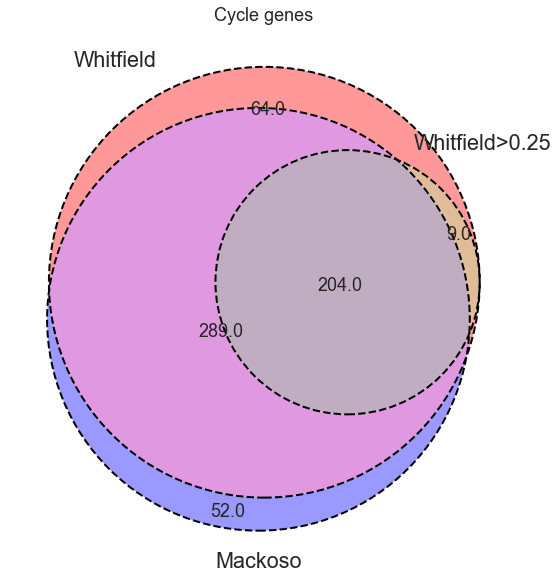

In [68]:
# in_Wf_above = cc_genes_Wf_red[cc_genes_Wf_red['above']].index.unique()

# A = pd.DataFrame(1,index=in_GO, columns=['GO'])
A = pd.DataFrame(1,index=cc_genes_red.index, columns=['a'])
# A = pd.DataFrame(1,index=df_red.columns, columns=['GO'])
# A.GO = 1
# in_liu = ad.var_names[ad.var_names.isin(cc_score_genes.index)]
# A = A.join(pd.DataFrame(1, index=genes_in_cb3, columns=['cb3']), how='outer')
A = A.join(pd.DataFrame(1, index=cc_genes_red[cc_genes_red.above].index, columns=['b']), how='outer')
# A = A.join(pd.DataFrame(1, index=in_Wf_above, columns=['domin']), how='outer')

A = A.join(pd.DataFrame(1, index=cc_mack_red.index, columns=['c']), how='outer')
A = A.fillna(0)
# A['cb3'] = pd.DataFrame(1, index=genes_in_cb3, columns=['cb3'])
A.sum()
sets_sizes = []
sets_sizes.append((A.a *(1-A.b) * (1-A.c)).sum())
sets_sizes.append(((1-A.a) *A.b * (1-A.c)).sum())
sets_sizes.append((A.a *A.b * (1-A.c)).sum())
sets_sizes.append(((1-A.a) *(1-A.b)* A.c).sum())
sets_sizes.append((A.a*(1-A.b)* A.c).sum())
sets_sizes.append(((1-A.a) *A.b* A.c).sum())
sets_sizes.append((A.a*A.b* A.c).sum())


#import module
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt

plt.figure(figsize=(10,10))
# depict venn diagram
# sets_labels = ['GO', 'Cyclebase3.0', 'whitfield>0.5.']
sets_labels = ['Whitfield', 'Whitfield>0.25', 'Mackoso']
v = venn3(subsets=sets_sizes, 
          set_labels=sets_labels)
# add outline
venn3_circles(sets_sizes, 
              linestyle="dashed", linewidth=2)
  
# assign title
plt.title("Cycle genes")
plt.show()

C:\Users\ronse\Anaconda3\lib\site-packages\matplotlib_venn\_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")


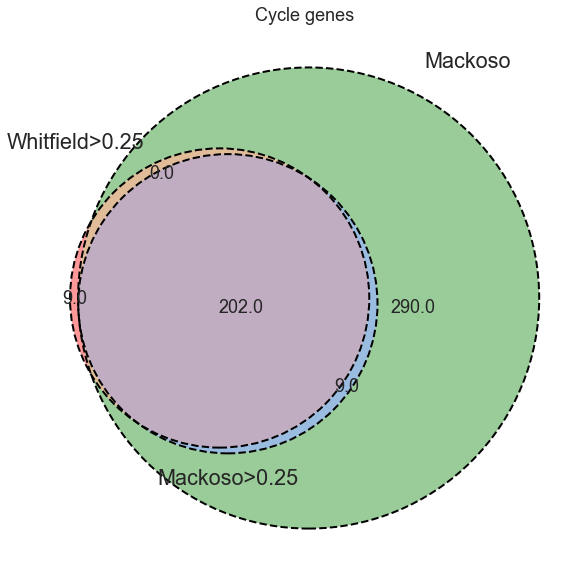

In [69]:
# in_Wf_above = cc_genes_Wf_red[cc_genes_Wf_red['above']].index.unique()

# A = pd.DataFrame(1,index=in_GO, columns=['GO'])
A = pd.DataFrame(1,index=cc_genes_red[cc_genes_red.above].index, columns=['a'])
# A = pd.DataFrame(1,index=df_red.columns, columns=['GO'])
# A.GO = 1
# in_liu = ad.var_names[ad.var_names.isin(cc_score_genes.index)]
# A = A.join(pd.DataFrame(1, index=genes_in_cb3, columns=['cb3']), how='outer')
A = A.join(pd.DataFrame(1, index=cc_mack_red.index, columns=['b']), how='outer')
# A = A.join(pd.DataFrame(1, index=in_Wf_above, columns=['domin']), how='outer')

A = A.join(pd.DataFrame(1, index=cc_mack_red[cc_mack_red.above].index, columns=['c']), how='outer')
A = A.fillna(0)
# A['cb3'] = pd.DataFrame(1, index=genes_in_cb3, columns=['cb3'])
A.sum()
sets_sizes = []
sets_sizes.append((A.a *(1-A.b) * (1-A.c)).sum())
sets_sizes.append(((1-A.a) *A.b * (1-A.c)).sum())
sets_sizes.append((A.a *A.b * (1-A.c)).sum())
sets_sizes.append(((1-A.a) *(1-A.b)* A.c).sum())
sets_sizes.append((A.a*(1-A.b)* A.c).sum())
sets_sizes.append(((1-A.a) *A.b* A.c).sum())
sets_sizes.append((A.a*A.b* A.c).sum())


#import module
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt

plt.figure(figsize=(10,10))
# depict venn diagram
# sets_labels = ['GO', 'Cyclebase3.0', 'whitfield>0.5.']
sets_labels = ['Whitfield>0.25', 'Mackoso', 'Mackoso>0.25']
v = venn3(subsets=sets_sizes, 
          set_labels=sets_labels)
# add outline
venn3_circles(sets_sizes, 
              linestyle="dashed", linewidth=2)
  
# assign title
plt.title("Cycle genes")
plt.show()